In [3]:
#Import all the necessary modules
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import random
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
import copy
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from random import randint

In [22]:
import re
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords.words('english')
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
industrial_safety_df = pd.read_csv("/content/drive/MyDrive/Capstone-project/Chatbot/Data/capstone/IHMStefanini_industrial_safety_and_health_database_with_accidents_description.csv")
industrial_safety_df.head()

,Unnamed: 0,Data,Countries,Local,Industry Sector,Accident Level,Potential Accident Level,Genre,Employee or Third Party,Critical Risk,Description
0,0,2016-01-01 00:00:00,Country_01,Local_01,Mining,I,IV,Male,Third Party,Pressed,While removing the drill rod of the Jumbo 08 f...
1,1,2016-01-02 00:00:00,Country_02,Local_02,Mining,I,IV,Male,Employee,Pressurized Systems,During the activation of a sodium sulphide pum...
2,2,2016-01-06 00:00:00,Country_01,Local_03,Mining,I,III,Male,Third Party (Remote),Manual Tools,In the sub-station MILPO located at level +170...
3,3,2016-01-08 00:00:00,Country_01,Local_04,Mining,I,I,Male,Third Party,Others,Being 9:45 am. approximately in the Nv. 1880 C...
4,4,2016-01-10 00:00:00,Country_01,Local_04,Mining,IV,IV,Male,Third Party,Others,Approximately at 11:45 a.m. in circumstances t...


In [ ]:
industrial_safety_df.shape

(425, 11)

### Grouping by Accident Level and Potential Accident Level 

In [6]:
group_acc_level = industrial_safety_df.groupby(['Accident Level'])
group_acc_level.first()

,Unnamed: 0,Data,Countries,Local,Industry Sector,Potential Accident Level,Genre,Employee or Third Party,Critical Risk,Description
Accident Level,,,,,,,,,,
I,0,2016-01-01 00:00:00,Country_01,Local_01,Mining,IV,Male,Third Party,Pressed,While removing the drill rod of the Jumbo 08 f...
II,22,2016-02-10 00:00:00,Country_01,Local_03,Mining,IV,Male,Third Party,Others,While aligning the right bracket of tower N ° ...
III,16,2016-02-06 00:00:00,Country_01,Local_04,Mining,IV,Male,Third Party,Others,"At Rp 050 of level 1620, in circumstances wher..."
IV,4,2016-01-10 00:00:00,Country_01,Local_04,Mining,IV,Male,Third Party,Others,Approximately at 11:45 a.m. in circumstances t...
V,33,2016-02-20 00:00:00,Country_01,Local_04,Mining,V,Male,Third Party,Others,Approximately 1:40 p.m. in circumstances that ...


In [7]:
group_ptnl_acc_level = industrial_safety_df.groupby(['Potential Accident Level'])
group_ptnl_acc_level.first()

,Unnamed: 0,Data,Countries,Local,Industry Sector,Accident Level,Genre,Employee or Third Party,Critical Risk,Description
Potential Accident Level,,,,,,,,,,
I,3,2016-01-08 00:00:00,Country_01,Local_04,Mining,I,Male,Third Party,Others,Being 9:45 am. approximately in the Nv. 1880 C...
II,9,2016-01-26 00:00:00,Country_01,Local_06,Metals,I,Male,Third Party,Chemical substances,At the moment the forklift operator went to ma...
III,2,2016-01-06 00:00:00,Country_01,Local_03,Mining,I,Male,Third Party (Remote),Manual Tools,In the sub-station MILPO located at level +170...
IV,0,2016-01-01 00:00:00,Country_01,Local_01,Mining,I,Male,Third Party,Pressed,While removing the drill rod of the Jumbo 08 f...
V,13,2016-02-02 00:00:00,Country_01,Local_01,Mining,IV,Male,Third Party,Electrical installation,"In moments that the operator of the Jumbo 2, t..."
VI,321,2017-01-25 00:00:00,Country_01,Local_03,Mining,V,Male,Third Party,remains of choco,During the process of loading drills in the Ca...


### DataSet Analysis- Basic EDA

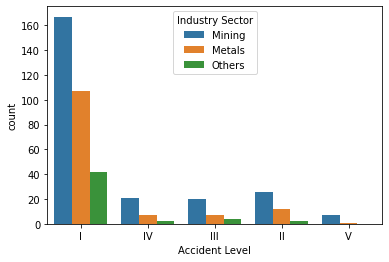

In [8]:
sns.countplot(x ='Accident Level', data = industrial_safety_df, hue ='Industry Sector'); 

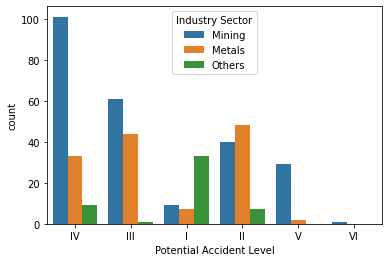

In [9]:
sns.countplot(x ='Potential Accident Level', data = industrial_safety_df, hue ='Industry Sector'); 

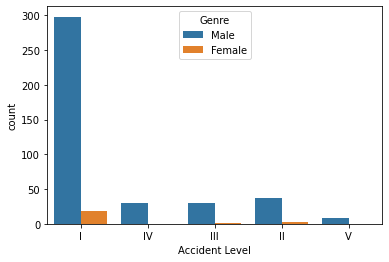

In [10]:
sns.countplot(x ='Accident Level', data = industrial_safety_df, hue ='Genre'); 

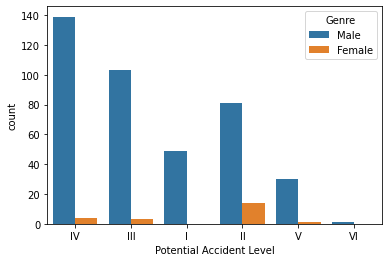

In [11]:
sns.countplot(x ='Potential Accident Level', data = industrial_safety_df, hue ='Genre'); 

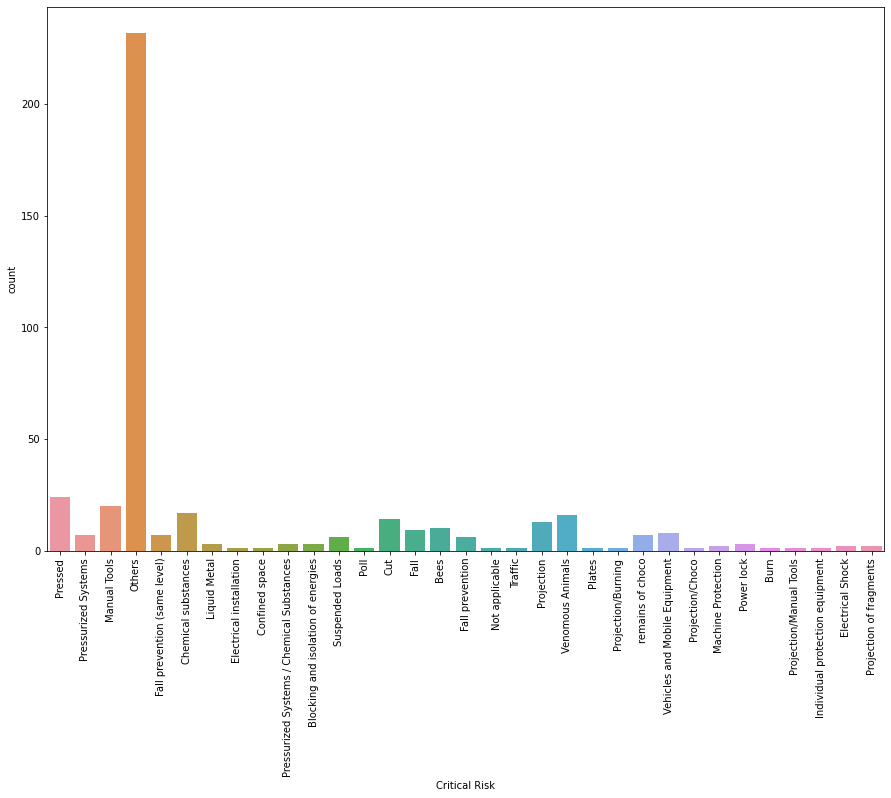

In [12]:
plt.figure(figsize=(15,10))
plt.setp(sns.countplot(industrial_safety_df['Critical Risk']).get_xticklabels(), rotation=90);

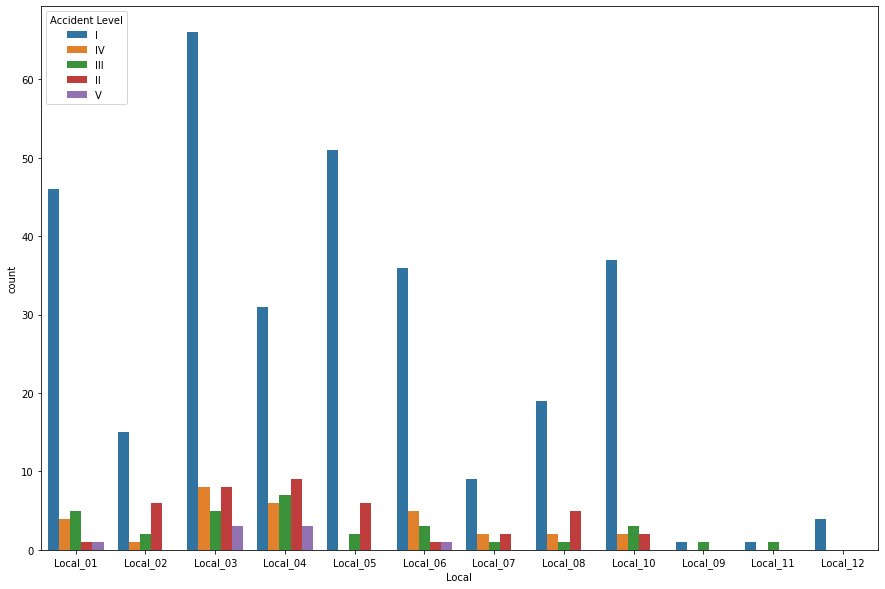

In [13]:
plt.figure(figsize=(15,10))
sns.countplot(industrial_safety_df['Local'], hue = industrial_safety_df['Accident Level']);

 - #### Labeling The Dataset
 > As per the dataset there are 1-6 level of Accident Level, here we have labeled 1-2 as low risk, 3-4 moderate risk and 5-6 critical risk 

In [14]:
def create_label(accident_level):
    level = str(accident_level)
    if level.__eq__("I") or level.__eq__("II"):
        return "low"
    if level.__eq__("III"):
        return "moderate"
    if level.__eq__("IV") or level.__eq__("V"):
        return "high"
    if level.__eq__("VI"):
        return "critical"
    
industrial_safety_df['Accident Severity'] = industrial_safety_df['Accident Level'].apply(create_label)
industrial_safety_df[['Accident Level','Accident Severity']]

,Accident Level,Accident Severity
0,I,low
1,I,low
2,I,low
3,I,low
4,IV,high
...,...,...
420,I,low
421,I,low
422,I,low
423,I,low


#### We can see that the Mining Sector is the most risky as the most number of accidents recorded in that sector followed by Metals

### Data Cleansing
 

In [15]:
#Renaming Data -> date, Genre -> Gender
#Removing the Column Unnamed as it's just sequence

industrial_safety_df.rename(columns = {'Data': 'Date', 'Genre': 'Gender'}, inplace = True)
industrial_safety_df = industrial_safety_df.drop("Unnamed: 0",axis=1)
industrial_safety_df.head()


,Date,Countries,Local,Industry Sector,Accident Level,Potential Accident Level,Gender,Employee or Third Party,Critical Risk,Description,Accident Severity
0,2016-01-01 00:00:00,Country_01,Local_01,Mining,I,IV,Male,Third Party,Pressed,While removing the drill rod of the Jumbo 08 f...,low
1,2016-01-02 00:00:00,Country_02,Local_02,Mining,I,IV,Male,Employee,Pressurized Systems,During the activation of a sodium sulphide pum...,low
2,2016-01-06 00:00:00,Country_01,Local_03,Mining,I,III,Male,Third Party (Remote),Manual Tools,In the sub-station MILPO located at level +170...,low
3,2016-01-08 00:00:00,Country_01,Local_04,Mining,I,I,Male,Third Party,Others,Being 9:45 am. approximately in the Nv. 1880 C...,low
4,2016-01-10 00:00:00,Country_01,Local_04,Mining,IV,IV,Male,Third Party,Others,Approximately at 11:45 a.m. in circumstances t...,high


In [16]:
industrial_safety_df.describe()

,Date,Countries,Local,Industry Sector,Accident Level,Potential Accident Level,Gender,Employee or Third Party,Critical Risk,Description,Accident Severity
count,425,425,425,425,425,425,425,425,425,425,425
unique,287,3,12,3,5,6,2,3,33,411,3
top,2017-02-08 00:00:00,Country_01,Local_03,Mining,I,IV,Male,Third Party,Others,During the activity of chuteo of ore in hopper...,low
freq,6,251,90,241,316,143,403,189,232,3,356


In [17]:
industrial_safety_df.isnull().sum()

Date                        0
Countries                   0
Local                       0
Industry Sector             0
Accident Level              0
Potential Accident Level    0
Gender                      0
Employee or Third Party     0
Critical Risk               0
Description                 0
Accident Severity           0
dtype: int64

In [18]:
industrial_safety_df.dtypes

Date                        object
Countries                   object
Local                       object
Industry Sector             object
Accident Level              object
Potential Accident Level    object
Gender                      object
Employee or Third Party     object
Critical Risk               object
Description                 object
Accident Severity           object
dtype: object

### Pre-Processing the Text 

- #### Removing all irrelevant characters (Numbers and Punctuation)

In [19]:
def remove_alpha_numerics(description_txt):
    return re.sub('[^a-zA-Z]',' ',description_txt)
industrial_safety_df['Updated Description'] = industrial_safety_df['Description'].apply(remove_alpha_numerics)
industrial_safety_df['Updated Description']

0      While removing the drill rod of the Jumbo    f...
1      During the activation of a sodium sulphide pum...
2      In the sub station MILPO located at level     ...
3      Being      am  approximately in the Nv       C...
4      Approximately at       a m  in circumstances t...
                             ...                        
420    Being approximately      a m  approximately  w...
421    The collaborator moved from the infrastructure...
422    During the environmental monitoring activity i...
423    The Employee performed the activity of strippi...
424    At       a m   when the assistant cleaned the ...
Name: Updated Description, Length: 425, dtype: object

- #### Convert all characters into lowercase

In [20]:
def to_lower_case(description_txt):
    return str(description_txt).lower()
industrial_safety_df['Updated Description'] = industrial_safety_df['Updated Description'].apply(to_lower_case)
industrial_safety_df['Updated Description']

0      while removing the drill rod of the jumbo    f...
1      during the activation of a sodium sulphide pum...
2      in the sub station milpo located at level     ...
3      being      am  approximately in the nv       c...
4      approximately at       a m  in circumstances t...
                             ...                        
420    being approximately      a m  approximately  w...
421    the collaborator moved from the infrastructure...
422    during the environmental monitoring activity i...
423    the employee performed the activity of strippi...
424    at       a m   when the assistant cleaned the ...
Name: Updated Description, Length: 425, dtype: object

- #### Tokenization 

In [23]:
industrial_safety_df['Updated Description'] = industrial_safety_df.apply(lambda word: nltk.word_tokenize(word['Updated Description']), axis=1)
industrial_safety_df['Updated Description']

0      [while, removing, the, drill, rod, of, the, ju...
1      [during, the, activation, of, a, sodium, sulph...
2      [in, the, sub, station, milpo, located, at, le...
3      [being, am, approximately, in, the, nv, cx, ob...
4      [approximately, at, a, m, in, circumstances, t...
                             ...                        
420    [being, approximately, a, m, approximately, wh...
421    [the, collaborator, moved, from, the, infrastr...
422    [during, the, environmental, monitoring, activ...
423    [the, employee, performed, the, activity, of, ...
424    [at, a, m, when, the, assistant, cleaned, the,...
Name: Updated Description, Length: 425, dtype: object

- #### Removing Stopwords

In [25]:
stop_words = set(stopwords.words('english'))
def remove_stopwords(word):
    return [token for token in word if not token in stop_words]
    
industrial_safety_df['Updated Description'] = industrial_safety_df['Updated Description'].apply(remove_stopwords)
industrial_safety_df['Updated Description']

0      [removing, drill, rod, jumbo, maintenance, sup...
1      [activation, sodium, sulphide, pump, piping, u...
2      [sub, station, milpo, located, level, collabor...
3      [approximately, nv, cx, ob, personnel, begins,...
4      [approximately, circumstances, mechanics, anth...
                             ...                        
420    [approximately, approximately, lifting, kelly,...
421    [collaborator, moved, infrastructure, office, ...
422    [environmental, monitoring, activity, area, em...
423    [employee, performed, activity, stripping, cat...
424    [assistant, cleaned, floor, module, e, central...
Name: Updated Description, Length: 425, dtype: object

- #### Stemming

In [26]:
stemmer = PorterStemmer()
def stem_tokens(tokens):
    return [stemmer.stem(index) for index in tokens]
industrial_safety_df['Updated Description Stems'] = industrial_safety_df['Updated Description'].apply(stem_tokens)
industrial_safety_df['Updated Description Stems']

0      [remov, drill, rod, jumbo, mainten, supervisor...
1      [activ, sodium, sulphid, pump, pipe, uncoupl, ...
2      [sub, station, milpo, locat, level, collabor, ...
3      [approxim, nv, cx, ob, personnel, begin, task,...
4      [approxim, circumst, mechan, anthoni, group, l...
                             ...                        
420    [approxim, approxim, lift, kelli, hq, toward, ...
421    [collabor, move, infrastructur, offic, julio, ...
422    [environment, monitor, activ, area, employe, s...
423    [employe, perform, activ, strip, cathod, pull,...
424    [assist, clean, floor, modul, e, central, camp...
Name: Updated Description Stems, Length: 425, dtype: object

#### As we can see due to stemming changed some of the words incorrectly, so we will do Lemmatization and compare

- #### Lemmatization

In [28]:
nltk.download('wordnet')
lemma = WordNetLemmatizer()
def lematize_tokens(tokens):
    return [lemma.lemmatize(word=w,pos='v') for w in tokens]
industrial_safety_df['Updated Description Lemmas'] = industrial_safety_df['Updated Description'].apply(lematize_tokens)
industrial_safety_df['Updated Description Lemmas']

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


0      [remove, drill, rod, jumbo, maintenance, super...
1      [activation, sodium, sulphide, pump, pip, unco...
2      [sub, station, milpo, locate, level, collabora...
3      [approximately, nv, cx, ob, personnel, begin, ...
4      [approximately, circumstances, mechanics, anth...
                             ...                        
420    [approximately, approximately, lift, kelly, hq...
421    [collaborator, move, infrastructure, office, j...
422    [environmental, monitor, activity, area, emplo...
423    [employee, perform, activity, strip, cathodes,...
424    [assistant, clean, floor, module, e, central, ...
Name: Updated Description Lemmas, Length: 425, dtype: object

- #### As we can see Lemmatization performed much better than the stemming so we will preffer lemmatization here 

#### Remove the words having length <= 2

In [29]:
# still few nonsense words exist in the lemmatized tokens
# we are going to remove those as they can be noise to the data
def remove_noise(tokens):
    return [i for i in tokens if len(i) > 2]
industrial_safety_df['Updated Description Lemmas'] = industrial_safety_df['Updated Description Lemmas'].apply(remove_noise)
industrial_safety_df['Updated Description Lemmas']

0      [remove, drill, rod, jumbo, maintenance, super...
1      [activation, sodium, sulphide, pump, pip, unco...
2      [sub, station, milpo, locate, level, collabora...
3      [approximately, personnel, begin, task, unlock...
4      [approximately, circumstances, mechanics, anth...
                             ...                        
420    [approximately, approximately, lift, kelly, to...
421    [collaborator, move, infrastructure, office, j...
422    [environmental, monitor, activity, area, emplo...
423    [employee, perform, activity, strip, cathodes,...
424    [assistant, clean, floor, module, central, cam...
Name: Updated Description Lemmas, Length: 425, dtype: object

- So this is the required corpus after text preprocessing. 
- now we will convert back this list to string for encoding the text.

### Final Text Data After Preprocessing

In [30]:
#Convert the list of tokens into back to the string
def to_string(tokens):
    return ' '.join(tokens)
industrial_safety_df['Updated Description'] = industrial_safety_df['Updated Description Lemmas'].apply(to_string)
industrial_safety_df['Updated Description']

0      remove drill rod jumbo maintenance supervisor ...
1      activation sodium sulphide pump pip uncouple s...
2      sub station milpo locate level collaborator ex...
3      approximately personnel begin task unlock soqu...
4      approximately circumstances mechanics anthony ...
                             ...                        
420    approximately approximately lift kelly towards...
421    collaborator move infrastructure office julio ...
422    environmental monitor activity area employee s...
423    employee perform activity strip cathodes pull ...
424    assistant clean floor module central camp slip...
Name: Updated Description, Length: 425, dtype: object

In [31]:
industrial_safety_df.head()

,Date,Countries,Local,Industry Sector,Accident Level,Potential Accident Level,Gender,Employee or Third Party,Critical Risk,Description,Accident Severity,Updated Description,Updated Description Stems,Updated Description Lemmas
0,2016-01-01 00:00:00,Country_01,Local_01,Mining,I,IV,Male,Third Party,Pressed,While removing the drill rod of the Jumbo 08 f...,low,remove drill rod jumbo maintenance supervisor ...,"[remov, drill, rod, jumbo, mainten, supervisor...","[remove, drill, rod, jumbo, maintenance, super..."
1,2016-01-02 00:00:00,Country_02,Local_02,Mining,I,IV,Male,Employee,Pressurized Systems,During the activation of a sodium sulphide pum...,low,activation sodium sulphide pump pip uncouple s...,"[activ, sodium, sulphid, pump, pipe, uncoupl, ...","[activation, sodium, sulphide, pump, pip, unco..."
2,2016-01-06 00:00:00,Country_01,Local_03,Mining,I,III,Male,Third Party (Remote),Manual Tools,In the sub-station MILPO located at level +170...,low,sub station milpo locate level collaborator ex...,"[sub, station, milpo, locat, level, collabor, ...","[sub, station, milpo, locate, level, collabora..."
3,2016-01-08 00:00:00,Country_01,Local_04,Mining,I,I,Male,Third Party,Others,Being 9:45 am. approximately in the Nv. 1880 C...,low,approximately personnel begin task unlock soqu...,"[approxim, nv, cx, ob, personnel, begin, task,...","[approximately, personnel, begin, task, unlock..."
4,2016-01-10 00:00:00,Country_01,Local_04,Mining,IV,IV,Male,Third Party,Others,Approximately at 11:45 a.m. in circumstances t...,high,approximately circumstances mechanics anthony ...,"[approxim, circumst, mechan, anthoni, group, l...","[approximately, circumstances, mechanics, anth..."


### Text Visualization
> Here we will try to visualize each token of the description

In [32]:
#splitting the dataset
#we will fecth the description tokens 
texts_in_severity_low = industrial_safety_df[industrial_safety_df['Accident Severity'] == "low"]['Updated Description'] 
texts_in_severity_moderate = industrial_safety_df[industrial_safety_df['Accident Severity'] == "moderate"]['Updated Description'] 
texts_in_severity_high = industrial_safety_df[industrial_safety_df['Accident Severity'] == "high"]['Updated Description'] 
texts_in_severity_critical = industrial_safety_df[industrial_safety_df['Accident Severity'] == "critical"]['Updated Description'] 


- Let’s visualize our corpus corresponding to the labels 
- Taking top 15 words and see their frequency in the corpus

In [33]:
from yellowbrick.text import FreqDistVisualizer
def show_text_freq(item):
    if(len(item) > 0):
        vectorizer = CountVectorizer()
        docs       = vectorizer.fit_transform(item)
        features   = vectorizer.get_feature_names()
        visualizer = FreqDistVisualizer(features=features, n=15, color='rgb', orient='V')
        visualizer.fit(docs)
        visualizer.show()
    else :
        print("Empty data-set")

AttributeError: ignored

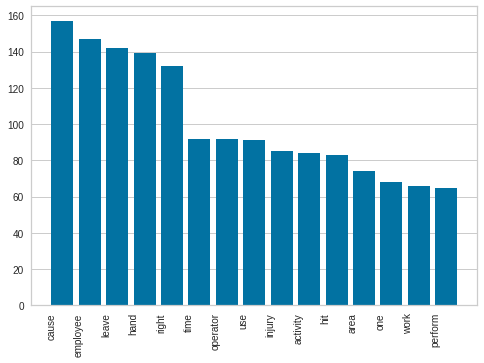

In [35]:
show_text_freq(texts_in_severity_low)

AttributeError: ignored

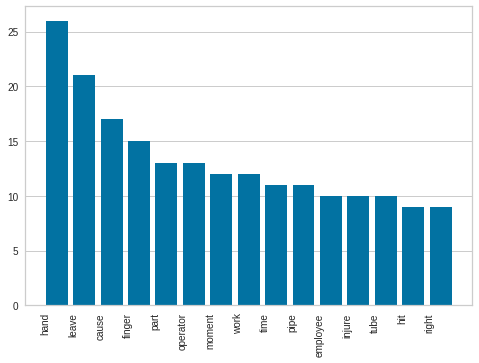

In [36]:
show_text_freq(texts_in_severity_moderate)

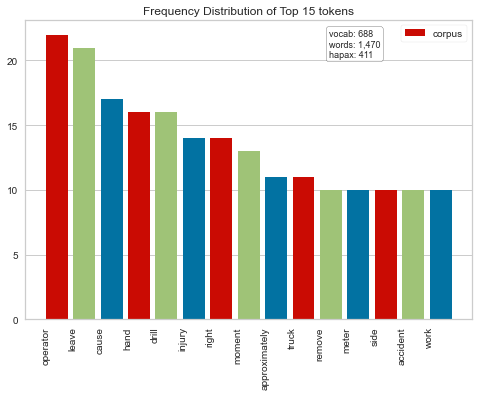

In [ ]:
show_text_freq(texts_in_severity_high)

In [37]:
show_text_freq(texts_in_severity_critical)

Empty data-set


In [38]:
industrial_safety_df.head()

,Date,Countries,Local,Industry Sector,Accident Level,Potential Accident Level,Gender,Employee or Third Party,Critical Risk,Description,Accident Severity,Updated Description,Updated Description Stems,Updated Description Lemmas
0,2016-01-01 00:00:00,Country_01,Local_01,Mining,I,IV,Male,Third Party,Pressed,While removing the drill rod of the Jumbo 08 f...,low,remove drill rod jumbo maintenance supervisor ...,"[remov, drill, rod, jumbo, mainten, supervisor...","[remove, drill, rod, jumbo, maintenance, super..."
1,2016-01-02 00:00:00,Country_02,Local_02,Mining,I,IV,Male,Employee,Pressurized Systems,During the activation of a sodium sulphide pum...,low,activation sodium sulphide pump pip uncouple s...,"[activ, sodium, sulphid, pump, pipe, uncoupl, ...","[activation, sodium, sulphide, pump, pip, unco..."
2,2016-01-06 00:00:00,Country_01,Local_03,Mining,I,III,Male,Third Party (Remote),Manual Tools,In the sub-station MILPO located at level +170...,low,sub station milpo locate level collaborator ex...,"[sub, station, milpo, locat, level, collabor, ...","[sub, station, milpo, locate, level, collabora..."
3,2016-01-08 00:00:00,Country_01,Local_04,Mining,I,I,Male,Third Party,Others,Being 9:45 am. approximately in the Nv. 1880 C...,low,approximately personnel begin task unlock soqu...,"[approxim, nv, cx, ob, personnel, begin, task,...","[approximately, personnel, begin, task, unlock..."
4,2016-01-10 00:00:00,Country_01,Local_04,Mining,IV,IV,Male,Third Party,Others,Approximately at 11:45 a.m. in circumstances t...,high,approximately circumstances mechanics anthony ...,"[approxim, circumst, mechan, anthoni, group, l...","[approximately, circumstances, mechanics, anth..."


> ## Data Encoding

> - ### Bag of Words

In [39]:
#creating the document or corpus
corpus_accident_description = industrial_safety_df['Description'].values
#corpus_accident_description

In [40]:
vec_bow = CountVectorizer()
X = vec_bow.fit_transform(corpus_accident_description)
features = vec_bow.get_feature_names()
#print(features)
print(X.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]


> - ### TF-IDF Encoding

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer
vec_tfidf = TfidfVectorizer()
X = vec_tfidf.fit_transform(corpus_accident_description)
words = vec_tfidf.get_feature_names()
#print(features)
tf_idf_df = pd.DataFrame(X.toarray())
tf_idf_df.columns = words
tf_idf_df

,00,001,007,01,018,0183,02,020,02bp0166,02bp0167,03,031,04,040,042,05,050,05m,06,069,07,08,08fi0502,09,0m,0x0,10,100,100cm,1021,105,1055,1095,10cm,10cmx8cm,10m,10mx0,10x6x5cm,11,110,...,wore,work,worked,worker,workers,working,workplace,works,workshop,worn,would,wound,wounding,wrench,wrist,x0,x1,x3,x32,x40cm,x6,xixás,xrd,xxx,yaranga,yard,ydrs,yields,yolk,you,young,your,z014,zaf,zamac,zero,zinc,zinco,zn,zone
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.13275,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.094401,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.1347,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.10747,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.141116,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.113764,0.0,...,0.0,0.000000,0.0,0.076318,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.158372,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420,0.191375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
421,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
422,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
423,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

 - ### Random Forest Classifier

In [42]:
#creaitng a new dataframe as per oure requirement
#not all features are important here

#without stop words and pre-processed
df1 = industrial_safety_df[['Potential Accident Level', 'Updated Description']].copy()
df1 = df1[df1['Potential Accident Level'] != 'VI'] # no value under VI

#with actual description
df2 = industrial_safety_df[['Potential Accident Level', 'Description']].copy()
df2 = df2[df2['Potential Accident Level'] != 'VI'] # no value under VI
df2
#pd.DataFrame(df1['Potential Accident Level'].unique()).values

,Potential Accident Level,Description
0,IV,While removing the drill rod of the Jumbo 08 f...
1,IV,During the activation of a sodium sulphide pum...
2,III,In the sub-station MILPO located at level +170...
3,I,Being 9:45 am. approximately in the Nv. 1880 C...
4,IV,Approximately at 11:45 a.m. in circumstances t...
...,...,...
420,III,"Being approximately 5:00 a.m. approximately, w..."
421,II,The collaborator moved from the infrastructure...
422,II,During the environmental monitoring activity i...
423,II,The Employee performed the activity of strippi...


- There are six different levels of Potential Accident Levels
- We need to replace each level as number

In [43]:
# Create a new column 'Potential_Accident_Level_Id' with encoded Ids 
df1['Potential_Accident_Level_Id'] = df1['Potential Accident Level'].factorize()[0]
Potential_Accident_Level_df = df1[['Potential Accident Level', 'Potential_Accident_Level_Id']].drop_duplicates()

#same for df2
df2['Potential_Accident_Level_Id'] = df2['Potential Accident Level'].factorize()[0]
Potential_Accident_Level_df2 = df2[['Potential Accident Level', 'Potential_Accident_Level_Id']].drop_duplicates()

# Dictionaries for future use(for unigrams and biGrams)
acc_level_to_id = dict(Potential_Accident_Level_df.values)
id_to_acc_level = dict(Potential_Accident_Level_df[['Potential_Accident_Level_Id', 'Potential Accident Level']].values)

# New dataframe
df1.head()
#pd.DataFrame(df1['Potential_Accident_Level_Id'].unique()).values

,Potential Accident Level,Updated Description,Potential_Accident_Level_Id
0,IV,remove drill rod jumbo maintenance supervisor ...,0
1,IV,activation sodium sulphide pump pip uncouple s...,0
2,III,sub station milpo locate level collaborator ex...,1
3,I,approximately personnel begin task unlock soqu...,2
4,IV,approximately circumstances mechanics anthony ...,0


- #### Above is the dataset that will be used by Rf-Classifier

In [44]:
#creating tf-idf for features
def tfidf_vectorizer(text):
    vec_tfidf = TfidfVectorizer()
    X = vec_tfidf.fit_transform(text)
    words = vec_tfidf.get_feature_names()
    #print(features)
    tf_idf_df = pd.DataFrame(X.toarray())
    tf_idf_df.columns = words
    return tf_idf_df

In [45]:
features_tfidf = tfidf_vectorizer(df1['Updated Description'])
target_label  = df1.Potential_Accident_Level_Id

In [46]:
# test_size is 0.3 as train : test is 70:30
features_train, features_test, target_train, target_test = train_test_split(features_tfidf, target_label, test_size=0.3, random_state=1)

In [47]:
rndm_clf = RandomForestClassifier(n_estimators = 1000, n_jobs=-1)
rndm_clf = rndm_clf.fit(features_train, target_train)
#score
predicted_target = rndm_clf.predict(features_test)
score_rf = round(rndm_clf.score(features_test , target_test),3)*100
print("Score - Random forest :",score_rf,"%")

Score - Random forest : 40.6 %


In [48]:
# Classification report
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(target_test, predicted_target, 
                                    target_names= df1['Potential Accident Level'].unique()))

				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

          IV       0.42      0.82      0.56        45
         III       0.18      0.14      0.16        29
           I       1.00      0.60      0.75        10
          II       0.36      0.11      0.17        36
           V       1.00      0.12      0.22         8

    accuracy                           0.41       128
   macro avg       0.59      0.36      0.37       128
weighted avg       0.43      0.41      0.35       128



- ##### Performace of the RF-classifer is very poor
- ##### We will change the dataset with stopwords and re-do

In [49]:
features_tfidf1 = tfidf_vectorizer(df2['Description'])
target_label1  = df2.Potential_Accident_Level_Id

In [50]:
# test_size is 0.3 as train : test is 70:30
features_train1, features_test1, target_train1, target_test1 = train_test_split(features_tfidf1, target_label1, test_size=0.3, random_state=1)

In [51]:
rndm_clf1 = RandomForestClassifier(n_estimators = 1000, n_jobs=-1)
rndm_clf1 = rndm_clf1.fit(features_train1, target_train1)
#score
predicted_target1 = rndm_clf1.predict(features_test1)
score_rf1 = round(rndm_clf1.score(features_test1, target_test1),3)*100
print("Score - Random forest :",score_rf,"%")

Score - Random forest : 40.6 %


In [52]:
# Classification report
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(target_test1, predicted_target1, 
                                    target_names= df2['Potential Accident Level'].unique()))

				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

          IV       0.44      0.84      0.58        45
         III       0.12      0.07      0.09        29
           I       1.00      0.60      0.75        10
          II       0.39      0.19      0.26        36
           V       1.00      0.12      0.22         8

    accuracy                           0.42       128
   macro avg       0.59      0.37      0.38       128
weighted avg       0.43      0.42      0.37       128



- #### Random Forest has failed to performed very poorly overall in this text classification

> ## Text Classification with FastText

In [54]:
!pip install fasttext
import fasttext 

     |████████████████████████████████| 71kB 3.1MB/s 
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3092085 sha256=34321ea040c1ee03affc1171d86c607ff9c60011ab07e4268b6a06e58b4a7cc8
  Stored in directory: /root/.cache/pip/wheels/98/ba/7f/b154944a1cf5a8cee91c154b75231136cc3a3321ab0e30f592
Successfully built fasttext


In [55]:
#FastText expects __label__ in each label
df_ftxt = industrial_safety_df[['Potential Accident Level', 'Updated Description']].copy()
df_ftxt['Potential Accident Level'] = ['__label__'+s for s in df_ftxt['Potential Accident Level']]
df_ftxt.head(15)

,Potential Accident Level,Updated Description
0,__label__IV,remove drill rod jumbo maintenance supervisor ...
1,__label__IV,activation sodium sulphide pump pip uncouple s...
2,__label__III,sub station milpo locate level collaborator ex...
3,__label__I,approximately personnel begin task unlock soqu...
4,__label__IV,approximately circumstances mechanics anthony ...
5,__label__III,unload operation ustulado bag need unclog disc...
6,__label__III,collaborator report street hold leave hand vol...
7,__label__III,approximately mechanic technician jos tecnomin...
8,__label__IV,employee sit rest area level raise bore suffer...
9,__label__II,moment forklift operator manipulate big bag bi...


In [58]:
#saving as txt file
import csv
df_ftxt[['Potential Accident Level','Updated Description']].to_csv(r'/content/drive/MyDrive/Capstone-project/Chatbot/Data/capstone/fasttext.datas-fasttext.txt', 
                                          index = False, 
                                          sep = ' ',
                                          header = None, 
                                          quoting = csv.QUOTE_NONE, 
                                          quotechar = "", 
                                          escapechar = " ")
df_ftxt.shape

(425, 2)

- #### the dataset has total 425 records. We will take 80% for training and 20% to test

>- Two dataset has been created using CLI
>- head -n 340 fasttext.datas-fasttext.txt > fastext.datas-fasttext-train.txt
>- head -n 85 fasttext.datas-fasttext.txt > fastext.datas-fasttext-test.txt

### Training & Evaluation of FastText
>To improve the performance of our model the wordNgrams parameter is set to 2. In other words, the model is being trained on bigrams instead of considering individual words.

In [ ]:
# Training the fastText classifier
ftxt_clf = fasttext.train_supervised('/content/drive/MyDrive/Capstone-project/Chatbot/Data/capstone/fasttext.datas-fasttext.txt', wordNgrams = 2, epoch=300)
# Save the trained model
ftxt_clf.save_model('model.bin')


In [ ]:
# Evaluating performance on the entire test file
ftxt_clf.test('fastext.datas-fasttext-train.txt')                      

(340, 0.9970588235294118, 0.9970588235294118)

In [ ]:
df_ftxt['pred']=df_ftxt['Updated Description'].map(lambda x: ftxt_clf.predict(x)[0][0])

In [ ]:
print(df_ftxt.shape,df_ftxt[df_ftxt.apply(lambda x: x['Potential Accident Level']!= x['pred'],axis=1)].shape)

(425, 3) (56, 3)


In [ ]:
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(df_ftxt['Potential Accident Level'], df_ftxt['pred'], 
                                    target_names= df_ftxt['Potential Accident Level'].unique()))

				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

 __label__IV       0.97      0.80      0.88        49
__label__III       0.78      0.87      0.83        95
  __label__I       0.83      0.93      0.88       106
 __label__II       0.91      0.90      0.90       143
  __label__V       1.00      0.61      0.76        31
 __label__VI       1.00      1.00      1.00         1

    accuracy                           0.87       425
   macro avg       0.92      0.85      0.87       425
weighted avg       0.88      0.87      0.87       425



In [ ]:
# Predicting on a single input
ftxt_clf.predict(df_ftxt.iloc[2,0])
df_ftxt.head()

,Potential Accident Level,Updated Description,pred
0,__label__IV,remove drill rod jumbo maintenance supervisor ...,__label__IV
1,__label__IV,activation sodium sulphide pump pip uncouple s...,__label__IV
2,__label__III,sub station milpo locate level collaborator ex...,__label__III
3,__label__I,approximately personnel begin task unlock soqu...,__label__I
4,__label__IV,approximately circumstances mechanics anthony ...,__label__IV


- #### Performance Tuning-FastText
> We will use gensim’s simple_preprocess method to tokenize our questions and remove symbols.

In [ ]:
# NLP Preprocessing
from gensim.utils import simple_preprocess
df = industrial_safety_df[['Potential Accident Level', 'Description']].copy()
df.shape                          
#dataset for training with preprocesed text
df_ftxt_train, df_ftxt_test, y1, y2 = train_test_split(df,df,test_size=0.3, random_state=1)

df_ftxt_train.iloc[:, 1] = df_ftxt_train.iloc[:, 1].apply(lambda x: ' '.join(simple_preprocess(x)))
df_ftxt_test.iloc[:, 1] = df_ftxt_test.iloc[:, 1].apply(lambda x: ' '.join(simple_preprocess(x)))

# Prefixing each row of the 'Potential Accident Level' column with '__label__'
df_ftxt_train.iloc[:, 0] = df_ftxt_train.iloc[:, 0].apply(lambda x: '__label__' + x)
df_ftxt_test.iloc[:, 0] = df_ftxt_test.iloc[:, 0].apply(lambda x: '__label__' + x)
df_ftxt_train.head()
#df.shape                                                         

,Potential Accident Level,Description
318,__label__IV,being hours approximately in circumstances tha...
232,__label__III,in the probe bore bapdd around hours the polli...
325,__label__III,while preparing to mount polypropylene tubing ...
127,__label__III,during the tests of the soft starter of the en...
82,__label__IV,when it opens the suction valve of the bo acid...


In [ ]:
#saving into text files
df_ftxt_train[['Potential Accident Level', 'Description']].to_csv('data-fasttext-train.txt', 
                                          index = False, 
                                          sep = ' ',
                                          header = None, 
                                          quoting = csv.QUOTE_NONE, 
                                          quotechar = "", 
                                          escapechar = " ")

df_ftxt_test[['Potential Accident Level', 'Description']].to_csv('data-fasttext-test.txt', 
                                          index = False, 
                                          sep = ' ',
                                          header = None, 
                                          quoting = csv.QUOTE_NONE, 
                                          quotechar = "", 
                                          escapechar = " ")

### Training and Performance Evaluation

In [ ]:
# Training the fastText classifier
ftxt_clf_gensim = fasttext.train_supervised('data-fasttext-train.txt', wordNgrams = 4, epoch=75, lr=0.5, loss='ova')
# Save the trained model
#model.save_model('model.bin')

In [ ]:
# Evaluating performance on the entire test file
ftxt_clf_gensim.test('data-fasttext-test.txt')   

(128, 0.4609375, 0.4609375)

In [ ]:
df_ftxt_test.head()

,Potential Accident Level,Description
172,__label__II,at level at the entrance of the locomotive wor...
78,__label__II,when accessing the santa do novo area in order...
122,__label__III,during the maintenance on the lx pump there wa...
376,__label__IV,on the employee de lima da silva was composing...
146,__label__IV,once the mooring of the faneles in the detonat...


In [ ]:
# Predicting on a single input
ftxt_clf_gensim.predict(df_ftxt_test.iloc[2, 0], k=-1, threshold=0.75)

(('__label__II', '__label__III'), array([1.00001001, 1.00001001]))

lets do wordcount here 

In [62]:
appos = {"ain't": "am not", "aren't": "are not", "can't": "cannot", 
         "can't've": "cannot have", "'cause": "because", 
         "could've": "could have", "couldn't": "could not", 
         "couldn't've": "could not have", "didn't": "did not", 
         "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
         "hadn't've": "had not have", "hasn't": "has not", 
         "haven't": "have not", "he'd": "he would", "he'd've": "he would have", 
         "he'll": "he will", "he'll've": "he will have", 
         "he's": "he is", "how'd": "how did", 
         "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
         "I'd": "I would", "I'd've": "I would have", "I'll": "I will", 
         "I'll've": "I will have", "I'm": "I am", "I've": "I have", 
         "isn't": "is not", "it'd": "it would", "it'd've": "it would have", 
         "it'll": "it will", "it'll've": "it will have", "it's": "it is", 
         "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
         "might've": "might have", "mightn't": "might not", 
         "mightn't've": "might not have", "must've": "must have", 
         "mustn't": "must not", "mustn't've": "must not have", 
         "needn't": "need not", "needn't've": "need not have",
         "o'clock": "of the clock", "oughtn't": "ought not", 
         "oughtn't've": "ought not have", "shan't": "shall not", 
         "sha'n't": "shall not", "shan't've": "shall not have", 
         "she'd": "she would", "she'd've": "she would have", 
         "she'll": "she will", "she'll've": "she will have",
         "she's": "she is", "should've": "should have", 
         "shouldn't": "should not", "shouldn't've": "should not have", 
         "so've": "so have", "so's": "so is", 
         "that'd": "that had", "that'd've": "that would have", 
         "that's": "that that is", "there'd": "there would", 
         "there'd've": "there would have", "there's": "there is", 
         "they'd": "they would", "they'd've": "they would have", 
         "they'll": "they will", "they'll've": "they will have", 
         "they're": "they are", "they've": "they have", 
         "to've": "to have", "wasn't": "was not", "we'd": "we would", 
         "we'd've": "we would have", "we'll": "we will", 
         "we'll've": "we will have", "we're": "we are", 
         "we've": "we have", "weren't": "were not", 
         "what'll": "what will", "what'll've": "what will have", 
         "what're": "what are", "what's": "what is", 
         "what've": "what have", "when's": "when is", 
         "when've": "when have", "where'd": "where did", 
         "where's": "where is", "where've": "where have", 
         "who'll": "who will", "who'll've": "who will have", 
         "who's": "who is", "who've": "who have", 
         "why's": "why is", "why've": "why have", "will've": "will have", 
         "won't": "will not", "won't've": "will not have",
         "would've": "would have", "wouldn't": "would not", 
         "wouldn't've": "would not have", "y'all": "you all", 
         "y'all'd": "you all would", "y'all'd've": "you all would have", 
         "y'all're": "you all are", "y'all've": "you all have", 
         "you'd": "you would", "you'd've": "you would have",
         "you'll": "you will", "you'll've": "you will have", 
         "you're": "you are", "you've": "you have"}

# Helper function to replace appos
def replace_words(headline):
    cleaned_headlines = []
    for word in str(headline).split():
        if word.lower() in appos.keys():
            cleaned_headlines.append(appos[word.lower()])
        else:
            cleaned_headlines.append(word)
    return ' '.join(cleaned_headlines)

# Helper function to remove punctuations
# Reference: https://www.programiz.com/python-programming/methods/string/translate
PUNCT_TO_REMOVE = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~' #string.punctuation
def remove_punctuation(text):
    """function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

# Helper function to lemmatize
lemmatizer = WordNetLemmatizer()
def lemmatize(text):
  return ''.join([lemmatizer.lemmatize(word) for word in text])

# Helper function to remove stopwords
stoplist = set(stopwords.words('english'))
stoplist.remove('not')
def remove_stopwords(text):
    """function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in stoplist])

# Helper function for wordcloud
# Reference: https://www.kaggle.com/aashita/word-clouds-of-various-shapes
def plot_wordcloud(text, mask = None, max_words = 500, max_font_size = 40, 
                   figure_size = (12, 6), title = None, title_size = 15):
    wordcloud = WordCloud(background_color = 'white', max_words = max_words,
                          random_state = 42, width = 350, height = 150, 
                          mask = mask, stopwords = stoplist, collocations = False)
    wordcloud.generate(str(text))
    
    plt.figure(figsize = figure_size)
    plt.imshow(wordcloud, interpolation = 'bilinear');
    plt.title(title, fontdict = {'size': title_size, 'color': 'black', 
                               'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()

lemmatizer = WordNetLemmatizer()
def lem(text):
    pos_dict = {'N': wn.NOUN, 'V': wn.VERB, 'J': wn.ADJ, 'R': wn.ADV}
    return(' '.join([lemmatizer.lemmatize(w,pos_dict.get(t, wn.NOUN)) for w,t in nltk.pos_tag(text.split())]))

Word Cloud


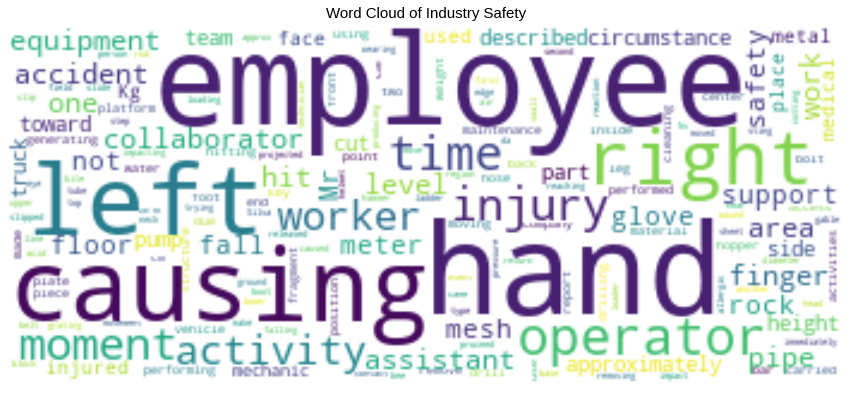

In [63]:
from wordcloud import WordCloud
print('Word Cloud')
print('=='*50)
industrial_safety_df['Description'] = industrial_safety_df['Description'].fillna('')
indStr = ' '.join(industrial_safety_df['Description'])
plot_wordcloud(indStr, title = 'Word Cloud of Industry Safety')

In [67]:
import re
import nltk
from nltk.tokenize import word_tokenize
#nltk.download('punkt')
from nltk.corpus import stopwords
#nltk.download('stopwords')
#stopwords.words('english')
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import nltk; nltk.download('wordnet'); nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
sns.set(style="darkgrid")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [65]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [68]:
print('\*'*30); 
print('Converting headlines to lower case')
industrial_safety_df['cleaned_Description'] = industrial_safety_df['Description'].apply(lambda x : x.lower())

print('Replacing apostrophes to the standard lexicons')
industrial_safety_df['cleaned_Description'] = industrial_safety_df['cleaned_Description'].apply(lambda x : replace_words(x))

print('Removing punctuations')
industrial_safety_df['cleaned_Description'] = industrial_safety_df['cleaned_Description'].apply(lambda x: remove_punctuation(x))

print('Applying Lemmatizer')
industrial_safety_df['cleaned_Description'] = industrial_safety_df['cleaned_Description'].apply(lambda x: lem(x))

print('Removing multiple spaces between words')
industrial_safety_df['cleaned_Description'] = industrial_safety_df['cleaned_Description'].apply(lambda x: re.sub(' +', ' ', x))

# print('Removing stopwords')
industrial_safety_df['cleaned_Description'] = industrial_safety_df['cleaned_Description'].apply(lambda x: remove_stopwords(x))
print('\*'*30)
industrial_safety_df.head()

\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*
Converting headlines to lower case
Replacing apostrophes to the standard lexicons
Removing punctuations
Applying Lemmatizer
Removing multiple spaces between words
\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*


,Date,Countries,Local,Industry Sector,Accident Level,Potential Accident Level,Gender,Employee or Third Party,Critical Risk,Description,Accident Severity,Updated Description,Updated Description Stems,Updated Description Lemmas,cleaned_Description
0,2016-01-01 00:00:00,Country_01,Local_01,Mining,I,IV,Male,Third Party,Pressed,While removing the drill rod of the Jumbo 08 f...,low,remove drill rod jumbo maintenance supervisor ...,"[remov, drill, rod, jumbo, mainten, supervisor...","[remove, drill, rod, jumbo, maintenance, super...",removing drill rod jumbo 08 maintenance superv...
1,2016-01-02 00:00:00,Country_02,Local_02,Mining,I,IV,Male,Employee,Pressurized Systems,During the activation of a sodium sulphide pum...,low,activation sodium sulphide pump pip uncouple s...,"[activ, sodium, sulphid, pump, pipe, uncoupl, ...","[activation, sodium, sulphide, pump, pip, unco...",activation sodium sulphide pump piping wa unco...
2,2016-01-06 00:00:00,Country_01,Local_03,Mining,I,III,Male,Third Party (Remote),Manual Tools,In the sub-station MILPO located at level +170...,low,sub station milpo locate level collaborator ex...,"[sub, station, milpo, locat, level, collabor, ...","[sub, station, milpo, locate, level, collabora...",substation milpo located level 170 collaborato...
3,2016-01-08 00:00:00,Country_01,Local_04,Mining,I,I,Male,Third Party,Others,Being 9:45 am. approximately in the Nv. 1880 C...,low,approximately personnel begin task unlock soqu...,"[approxim, nv, cx, ob, personnel, begin, task,...","[approximately, personnel, begin, task, unlock...",945 approximately nv 1880 cx695 ob7 personnel ...
4,2016-01-10 00:00:00,Country_01,Local_04,Mining,IV,IV,Male,Third Party,Others,Approximately at 11:45 a.m. in circumstances t...,high,approximately circumstances mechanics anthony ...,"[approxim, circumst, mechan, anthoni, group, l...","[approximately, circumstances, mechanics, anth...",approximately 1145 circumstance mechanic antho...


## Generating embedding GloVE



In [70]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout

In [71]:
max_features = 3213
maxlen = 30
embedding_size = 300

from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=max_features,lower=True)
tokenizer.fit_on_texts(industrial_safety_df['cleaned_Description'])

seq = tokenizer.texts_to_sequences(industrial_safety_df['cleaned_Description'])
padded= pad_sequences(seq,maxlen=maxlen,padding="post")

X=padded

In [72]:
tokenizer.word_index

{'wa': 1,
 'employee': 2,
 'hand': 3,
 'causing': 4,
 'left': 5,
 'right': 6,
 'operator': 7,
 'activity': 8,
 'time': 9,
 'injury': 10,
 'moment': 11,
 'worker': 12,
 'collaborator': 13,
 'area': 14,
 'one': 15,
 'work': 16,
 'equipment': 17,
 'finger': 18,
 'assistant': 19,
 'accident': 20,
 'pipe': 21,
 'level': 22,
 'hit': 23,
 'floor': 24,
 'support': 25,
 'mesh': 26,
 'rock': 27,
 'fall': 28,
 'not': 29,
 'mr': 30,
 'safety': 31,
 'glove': 32,
 'meter': 33,
 'team': 34,
 'approximately': 35,
 'height': 36,
 'part': 37,
 'side': 38,
 'described': 39,
 'circumstance': 40,
 'pump': 41,
 'truck': 42,
 'face': 43,
 'cut': 44,
 'metal': 45,
 'used': 46,
 'kg': 47,
 'injured': 48,
 'place': 49,
 'towards': 50,
 'medical': 51,
 'performing': 52,
 'mechanic': 53,
 'two': 54,
 'using': 55,
 'point': 56,
 'foot': 57,
 'platform': 58,
 'made': 59,
 'cm': 60,
 'remove': 61,
 'end': 62,
 'performed': 63,
 'generating': 64,
 'access': 65,
 'maintenance': 66,
 'fragment': 67,
 'inside': 68,
 '2'

In [73]:
num_words = len(tokenizer.word_index) + 1
print(num_words)

3213


In [75]:
import numpy as np
EMBEDDING_FILE = '/content/drive/MyDrive/Capstone-project/Chatbot/Data/glove.6B.300d.txt'

embeddings = {}
for o in open(EMBEDDING_FILE):
    word = o.split(" ")[0]
    # print(word)
    embd = o.split(" ")[1:]
    embd = np.asarray(embd, dtype='float32')
    # print(embd)
    embeddings[word] = embd

# create a weight matrix for words in training docs
embedding_matrix = np.zeros((num_words, 300))

for word, i in tokenizer.word_index.items():
	embedding_vector = embeddings.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

In [76]:
embedding_matrix.shape

(3213, 300)

In [77]:
embedding_matrix[1]


array([ 0.13053   , -0.11906   , -0.43076   ,  0.52701002, -0.43518001,
       -0.091907  , -0.31525999,  0.23774   , -0.095145  , -0.14505   ,
        0.15854   , -0.23717   , -0.35506001,  0.099615  ,  0.38429001,
       -0.072857  , -0.45506001,  0.65009999,  0.062081  ,  0.0017903 ,
       -0.54110003, -0.11608   ,  0.24789999,  0.31707001, -0.062319  ,
        0.022712  ,  0.13663   , -0.45543   ,  0.46752   , -0.52217001,
        0.62923998, -0.45091   ,  0.70539999,  0.63935   ,  0.39219999,
       -0.035215  ,  0.038173  , -0.039306  , -0.49895   , -0.27175   ,
        0.025864  , -0.83450001, -0.14706001,  0.11938   ,  0.029906  ,
       -0.20898999, -0.38993001, -0.11933   , -0.25595   , -0.68156999,
       -0.21164   , -0.026537  ,  0.3457    ,  0.016647  , -0.50885999,
        0.031879  ,  0.22402   ,  0.17292   ,  0.015874  , -0.61616999,
        0.14723   ,  0.30394   , -0.42519999,  0.042489  ,  0.6541    ,
       -0.41012001, -0.11586   , -0.18581   ,  0.28195   ,  0.67

In [78]:
### Vocabulary size
voc_size=5000

#glove and glove100 and 300,multilayer bidirectional ///
embedding_vector_features=100
model=Sequential()
model.add(Embedding(max_features, embedding_size,input_length = maxlen,weights = [embedding_matrix]))
# model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
# model.add(Bidirectional(LSTM(100,return_sequences=True)))
model.add(Bidirectional(LSTM(100)))
# model.add(Dense(10, activation='relu'))
model.add(Dense(5, activation='softmax'))
# model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 300)           963900    
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               320800    
_________________________________________________________________
dense (Dense)                (None, 5)                 1005      
Total params: 1,285,705
Trainable params: 1,285,705
Non-trainable params: 0
_________________________________________________________________
None


In [79]:

model1 = Sequential()
model1.add(Embedding(max_features, 300, input_length=maxlen,weights = [embedding_matrix]))
# model1.add(LSTM(units=100, dropout=0.2, recurrent_dropout=0.2))
# model1.add(LSTM(units=100, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
# model1.add(Bidirectional(LSTM(150,return_sequences=True)))
model1.add(LSTM(units=100, recurrent_dropout=0.2))
# model1.add(Dropout(0.2))
model1.add(Dense(50, activation='relu'))
model1.add(Dense(5, activation='softmax'))
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model1.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 300)           963900    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 255       
Total params: 1,129,605
Trainable params: 1,129,605
Non-trainable params: 0
_________________________________________________________________
None


In [80]:
y_acc=industrial_safety_df['Accident Level']

In [81]:
y_acc

0       I
1       I
2       I
3       I
4      IV
       ..
420     I
421     I
422     I
423     I
424     I
Name: Accident Level, Length: 425, dtype: object

In [82]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(y_acc)
encoded_Y= encoder.transform(y_acc)

In [83]:
encoded_Y.shape

(425,)

In [84]:
encoded_Y

array([0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 2, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 2, 4, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 1, 0, 0, 0, 0, 1, 3, 0, 0, 0, 0,
       0, 3, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 1, 3, 0, 0, 2, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 3, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 4, 1, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       3, 3, 0, 0, 0, 0, 0, 0, 4, 2, 0, 0, 3, 0, 2, 2, 3, 2, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 3, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 2, 3, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 1, 0, 2, 0, 1, 2, 3, 0, 0,
       1, 0, 2, 0, 0, 3, 3, 0, 0, 3, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 0, 0, 3, 2, 0,
       0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 2, 3,

In [85]:
from keras.utils import np_utils
dummy_y= np_utils.to_categorical(encoded_Y)
import numpy as np
X_acc=np.array(X)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_acc, dummy_y, test_size=0.33, random_state=42,shuffle=True)

In [86]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=150,batch_size=30)

Epoch 1/150
10/10 [==============================] - 6s 226ms/step - loss: 1.3667 - accuracy: 0.5005 - val_loss: 0.8513 - val_accuracy: 0.7801
Epoch 2/150
10/10 [==============================] - 1s 121ms/step - loss: 0.8975 - accuracy: 0.7153 - val_loss: 0.8724 - val_accuracy: 0.7801
Epoch 3/150
10/10 [==============================] - 1s 114ms/step - loss: 0.7219 - accuracy: 0.7531 - val_loss: 0.8559 - val_accuracy: 0.7801
Epoch 4/150
10/10 [==============================] - 1s 113ms/step - loss: 0.5982 - accuracy: 0.7867 - val_loss: 0.8455 - val_accuracy: 0.7660
Epoch 5/150
10/10 [==============================] - 1s 114ms/step - loss: 0.4927 - accuracy: 0.8192 - val_loss: 0.8892 - val_accuracy: 0.7163
Epoch 6/150
10/10 [==============================] - 1s 114ms/step - loss: 0.3540 - accuracy: 0.9020 - val_loss: 0.8446 - val_accuracy: 0.7518
Epoch 7/150
10/10 [==============================] - 1s 113ms/step - loss: 0.1601 - accuracy: 0.9625 - val_loss: 0.9146 - val_accuracy: 0.7234

In [87]:
model1.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=150,batch_size=30)

Epoch 1/150
10/10 [==============================] - 4s 147ms/step - loss: 1.5406 - accuracy: 0.3326 - val_loss: 0.9725 - val_accuracy: 0.7801
Epoch 2/150
10/10 [==============================] - 1s 102ms/step - loss: 1.0154 - accuracy: 0.7393 - val_loss: 0.8144 - val_accuracy: 0.7801
Epoch 3/150
10/10 [==============================] - 1s 103ms/step - loss: 1.0026 - accuracy: 0.6937 - val_loss: 0.8589 - val_accuracy: 0.7801
Epoch 4/150
10/10 [==============================] - 1s 102ms/step - loss: 0.8569 - accuracy: 0.7332 - val_loss: 0.8230 - val_accuracy: 0.7801
Epoch 5/150
10/10 [==============================] - 1s 101ms/step - loss: 0.8367 - accuracy: 0.7253 - val_loss: 0.8288 - val_accuracy: 0.7801
Epoch 6/150
10/10 [==============================] - 1s 104ms/step - loss: 0.8126 - accuracy: 0.7096 - val_loss: 0.8355 - val_accuracy: 0.7801
Epoch 7/150
10/10 [==============================] - 1s 103ms/step - loss: 0.6706 - accuracy: 0.7449 - val_loss: 0.8318 - val_accuracy: 0.7801

In [88]:
model.evaluate(X_test, y_test)

5/5 [==============================] - 0s 26ms/step - loss: 1.9100 - accuracy: 0.7376


[1.9099761247634888, 0.73758864402771]

In [89]:
model1.evaluate(X_test, y_test)

5/5 [==============================] - 0s 14ms/step - loss: 2.4199 - accuracy: 0.7376


[2.4199323654174805, 0.73758864402771]

Model Name	Accuracy	Comment
Random Forest Classifier	41.40%	We got very bad accuracy with RFC
FastText	99.70%	We got very good accuracy with FastText model with epoch of 300
Bidirectional LSTM	73%	We got decent accuracy with bidirectional LSTM(both with and without dropout and batch normalization)but there is huge difference between accuracy and validation accuracy
LSTM	67%	As compare to above model accuracy is low and same is above huge difference between accuracy and validation accuracy (both with and without dropout and batch normalization)
LSTM with LeakyReLU
	73%	as compare to above model accuracy is low and same is above huge difference between accuracy and validation accuracy
GRU	0.9%	Both accuracy and validation accuracy were very low
